In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

plt.ion()

from PIL import Image
# Verificar si hay una GPU disponible
print(torch.cuda.is_available())

# Establecer la GPU como dispositivo predeterminado
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [ ]:
data_transforms = {
       'train_or': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), #data augmentation
        transforms.ToTensor(),       # Convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
    'test': transforms.Compose([
        transforms.Resize(256),       # Resize the short side of the image to 150 keeping aspect ratio
        transforms.CenterCrop(224),   # Crop a square in the center of the image
        transforms.ToTensor(),        # Convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# Loading datasets with Pytorch ImageFolder
data_dir = '/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/All_images'

image_datasets_or = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_or', 'test']}

class_names = image_datasets_or['train_or'].classes
num_clases=len(class_names)
num_im_train_or,num_im_test=len(image_datasets_or['train_or']),len(image_datasets_or['test'])


Separamos el conjunto de train_or en train y val

In [ ]:
from sklearn.model_selection import train_test_split

images=[img for img,class_idx in image_datasets_or['train_or'].imgs]
#labels es una lista con el indicie que indica la clase de cada imagen en el dataset train. Dimension[num_im_train,]
labels=np.array([label for _,label in image_datasets_or['train_or'].imgs])

# Crea un arreglo de índices para tus imágenes
indices = np.arange(len(images))

# Usa train_test_split para dividir los índices en dos subconjuntos, train y validación
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

# Crea los subconjuntos de imágenes y etiquetas correspondientes
train_images = [images[idx] for idx in train_idx]
val_images = [images[idx] for idx in val_idx]
train_labels = [labels[idx] for idx in train_idx]
val_labels = [labels[idx] for idx in val_idx]

NameError: ignored

In [ ]:
#creamos las carpetas de train y val
train_folder = os.path.join(data_dir, 'train')
if not os.path.exists(train_folder):
    os.mkdir(train_folder)
    
val_folder = os.path.join(data_dir, 'val')
if not os.path.exists(val_folder):
    os.mkdir(val_folder)

#creamos las subcarpetas para cada clase
for fold in ['train','val']:
    folder=os.path.join(data_dir,fold)
    for class_name in class_names:
        class_dir = os.path.join(folder, class_name)
        if not os.path.exists(class_dir):
            os.mkdir(class_dir)   
 

for (path, class_id) in image_datasets_or['train_or'].imgs:
    if path in train_images:
        class_name = class_names[class_id]
        class_dir = os.path.join(train_folder, class_name)
        if not os.path.exists(os.path.join(train_folder, os.path.basename(path))):
            shutil.copy2(path, class_dir)
    if path in val_images:
        class_name = class_names[class_id]
        class_dir = os.path.join(val_folder, class_name)
        if not os.path.exists(os.path.join(val_folder, os.path.basename(path))):
            shutil.copy2(path, class_dir)


NameError: ignored

In [8]:
data_dir = '/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/All_images'
data_transforms = {
       'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), #data augmentation
        transforms.ToTensor(),       # Convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
    'val': transforms.Compose([
        transforms.Resize(256),       # Resize the short side of the image to 150 keeping aspect ratio
        transforms.CenterCrop(224),   # Crop a square in the center of the image
        transforms.ToTensor(),        # Convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),       # Resize the short side of the image to 150 keeping aspect ratio
        transforms.CenterCrop(224),   # Crop a square in the center of the image
        transforms.ToTensor(),        # Convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [16]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

num_im_train,num_im_val=len(image_datasets['train']),len(image_datasets['val'])

# import math
# size_batches=math.gcd(num_im_train,num_im_val)
# size_batches=math.gcd(size_batches,num_im_test)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

class_names = image_datasets['train'].classes
num_clases=len(class_names)

trainloader=dataloaders['train']
valloader=dataloaders['val']
testloader=dataloaders['test']

print(class_names)

['Documents', 'Plans', 'Tickets']


In [ ]:
for img,idx in image_datasets['train']:
  print (img.shape)
  pass

In [ ]:
class_to_idx = image_datasets['train'].class_to_idx #diccionario con el indice que representa cada clase

class_counts_train = {cls: 0 for cls in class_to_idx.keys()} #iniciarlizar diccionario con el numero de imagenes de cada clase a 0
class_counts_val = {cls: 0 for cls in class_to_idx.keys()}
class_counts_test = {cls: 0 for cls in class_to_idx.keys()}

#el conjunto image_datasets['train'] es una lista de tuples. Cada tuple es: (tensor que representa la imagen,indice que representa la clase a la que pertenece)
for img, cls in image_datasets['train']:
    if cls==0:
        class_counts_train['Documents'] += 1
    if cls==1:
        class_counts_train['Plans'] += 1
    if cls==2:
        class_counts_train['Tickets'] += 1
        
for img, cls in image_datasets['val']:
    if cls==0:
        class_counts_val['Documents'] += 1
    if cls==1:
        class_counts_val['Plans'] += 1
    if cls==2:
        class_counts_val['Tickets'] += 1 

for img, cls in image_datasets['test']:
    if cls==0:
        class_counts_test['Documents'] += 1
    if cls==1:
        class_counts_test['Plans'] += 1
    if cls==2:
        class_counts_test['Tickets'] += 1
        
print('Train: ',class_counts_train)
print('Val: ',class_counts_val)
print('Test: ',class_counts_test)


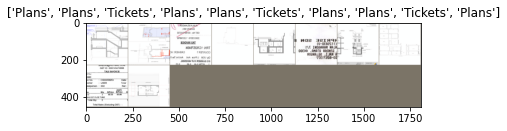

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        scheduler.step()    
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Congelamos los parámetros del modelo, y añadimos una última capa que es la que entrenaremos.

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_clases)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
torch.save({
            'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'scheduler_state_dict': exp_lr_scheduler.state_dict(),
            }, '/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/checkpoint.pt')
checkpoint = torch.load('/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/checkpoint.pt')
model_conv.load_state_dict(checkpoint['model_state_dict'])
optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
model_conv.eval()


In [5]:
#para guardar el modelo modo checkpoint (por si quiero seguir entrenandolo)
# torch.save({
#             'model_state_dict': model_conv.state_dict(),
#             'optimizer_state_dict': optimizer_conv.state_dict(),
#             'scheduler_state_dict': exp_lr_scheduler.state_dict(),
#             }, '/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/checkpoint.pt')

checkpoint = torch.load('/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/checkpoint.pt')
model_conv.load_state_dict(checkpoint['model_state_dict'])
optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
model_conv.eval()

visualize_model(model_conv)

plt.ioff()
plt.show()

NameError: ignored

In [ ]:
#para guardarlo y no tener que instanciarlo, pero sigue haciendo falta definir la clase model_conv
torch.save(model_conv,'/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/trained_model2.pt')

In [ ]:
path_model='/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/'
path_model+'traced_model.zip'

'/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/traced_model.zip'

Exportarlo y usarlo en otras aplicaciones:. tracing y scripting. Sigue necesitando torchscript (o python o C++)


In [ ]:

#tracing: utiliza el input para hacer las operaciones que determine el modelo, pero si hay alguna ramificación no la captura

# path_model='/content/drive/MyDrive/TOP_ROSIES/Challenge_HP/'
# input=torch.rand(10,3,24,24)
# traced_model=torch.jit.trace(model_conv.cpu(),input)
# traced_model.save(path_model+'traced_model.zip')

loaded_model=torch.jit.load(path_model+'traced_model.zip')

#scripted: captura todas las operaciones. 
scripted_model=torch.jit.script(model_conv.cpu())
scripted_model.save(path_model+'scripted_model.zip')

Train set classification report

              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.99      0.98      0.99       446
           2       0.92      0.99      0.95       169

    accuracy                           0.97       626
   macro avg       0.97      0.81      0.85       626
weighted avg       0.97      0.97      0.97       626



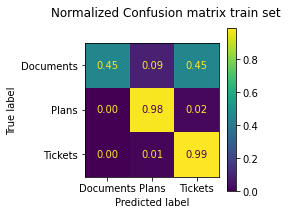

Validation set classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.99      1.00       112
           2       0.98      1.00      0.99        42

    accuracy                           0.99       157
   macro avg       0.99      1.00      0.99       157
weighted avg       0.99      0.99      0.99       157



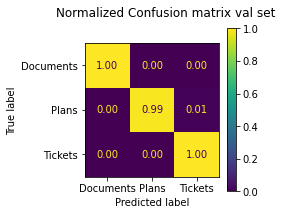

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
       
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_conv(inputs)
        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) #save prediction

        labels =labels.data.cpu().numpy()
        y_true.extend(labels)   #save truth

print("Train set classification report\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true,y_pred,normalize='true')
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(3,3))
display.plot(ax=ax, values_format='.2f')
fig.suptitle('Normalized Confusion matrix train set')
plt.show()

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
       
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_conv(inputs)
        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) #save prediction

        labels =labels.data.cpu().numpy()
        y_true.extend(labels)   #save truth

print("Validation set classification report\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true,y_pred, normalize='true')
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(3,3))
display.plot(ax=ax, values_format='.2f')
fig.suptitle('Normalized Confusion matrix val set')
plt.show()



In [ ]:
#Confusion matrix on test data
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
       
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_conv(inputs)
        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) #save prediction

        labels =labels.data.cpu().numpy()
        y_true.extend(labels)   #save truth

print("Test set classification report\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true,y_pred, normalize='true')
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(3,3))
display.plot(ax=ax, values_format='.2f')
fig.suptitle('Normalized Confusion matrix test set')
plt.show()

NameError: ignored